In [13]:
import datetime
import os
import numpy as np 
import pandas as pd
import glob

from qerr_utils import *
pd.options.mode.chained_assignment = None  # default='warn'

In [41]:
# Get a list of files in a directory
def getFiles(dirName):
    # os.chdir()
    allFiles = np.asarray(glob.glob(f"{dirName}/*.txt"))
    # Sort files - Note that this will not work if you have a different enumeration setup (e.g. you don't have an underscore)
    allFiles = sorted(allFiles, key = lambda x: float(x[x.rindex('_') + 1:x.index('.')]))
    return allFiles[:]

# Read data from data files
def getData(aFile):
    times = []
    deltas = []
    with open(aFile, 'r') as f:
        f.readline()
        for aLine in f:
            holder = aLine.split('\t')
            aDate = datetime.datetime.strptime(holder[0], '%m/%d/%Y %H:%M:%S.%f:')
            if float(holder[1].strip()) < 1e5:
                times.append(aDate)
                deltas.append(float(holder[1].strip()))
    return times, deltas

def scope_to_df(dataDir):
    allFiles = getFiles(dataDir)

    allTimes = []
    allDeltas = []
    
    # Get a list of files
    for aFile in allFiles:
        holderTimes, holderDeltas = getData(aFile)
        allTimes = np.concatenate((allTimes, holderTimes))
        allDeltas = np.concatenate((allDeltas, holderDeltas))
    
    df = pd.DataFrame(
        {
            'unix_timestamp': allTimes,
            'delta': allDeltas
        }
    )
    return df


def qerr_vs_time(df, scope_name):
    df['seconds elapsed'] = (df['towMS (ms)'] - df['towMS (ms)'].min()) / 10**3
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    sns.lineplot(df, x='seconds elapsed', y='qErr (ps)', linewidth=1.2, ax=ax)
    sns.regplot(df, x='seconds elapsed', y='qErr (ps)', scatter=True, ax=ax, order=15, scatter_kws={'s':2})
    
    ax.set_title(f'Q-Errors (ps) vs Elapsed Time (s) [{scope_name}]');
    ax.set_xlabel('Elapsed Time (s)')
    ax.set_ylabel('Q-Errors (ps)')

def qerr_hist(df):
    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.histplot(df, x='qErr (ps)', stat='density', ax=ax)
    ax.set_title('Distribution of Q-Errors (ps)')
    ax.set_xlabel('Q-Errors (ps)');

def load_merged_df(merged_fpath):
    df = load_data(merged_fpath)
    df['unix_timestamp'] = df['pkt_unix_timestamp_TIM-TP'].astype('datetime64[ns]')
    df['qErr (ns)'] = df['qErr (ps)'] * 1e-3
    return df

In [42]:
fpath_s3 = '/Users/nico/panoseti/gnss-pdft/qerr/data/start_2024-06-28T13:32:07.396892.device_ttyS3/data-type_MERGED.start_2024-06-28T13:32:07.396892'
fpath_s5 = '/Users/nico/panoseti/gnss-pdft/qerr/data/start_2024-06-28T13:32:32.459060.device_ttyS5/data-type_MERGED.start_2024-06-28T13:32:32.459060'

s3 = load_merged_df(fpath_s3)
s5 = load_merged_df(fpath_s5)

In [4]:
d = scope_to_df('/Users/nico/panoseti/gnss-pdft/scope/ScopeData/survey-in-end-20240628')

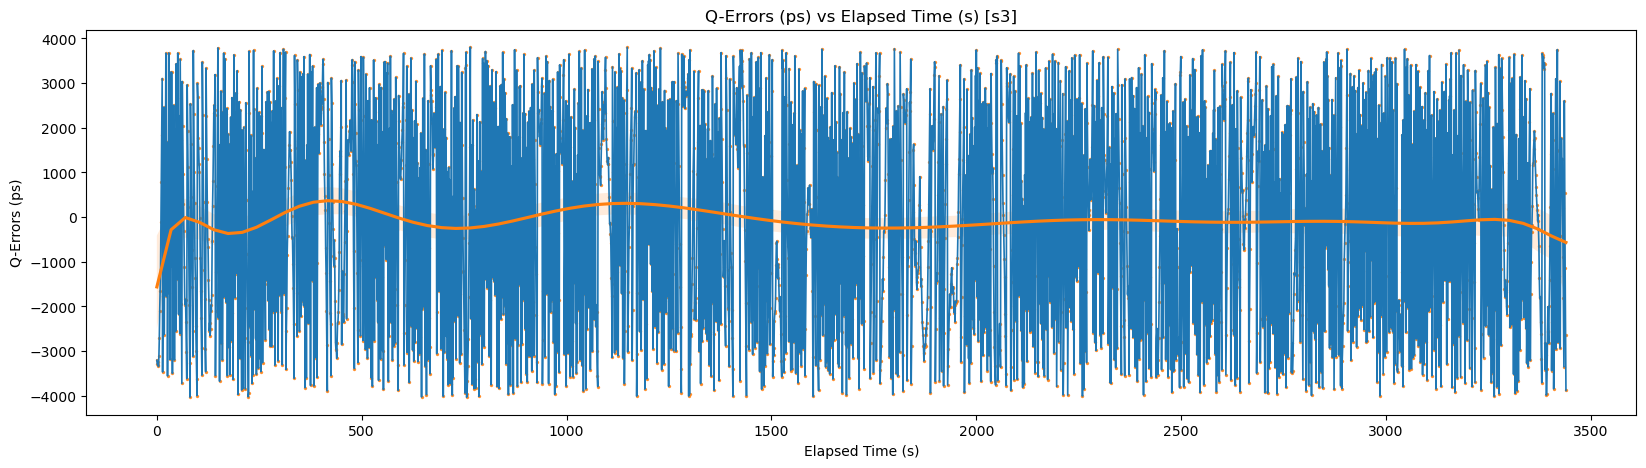

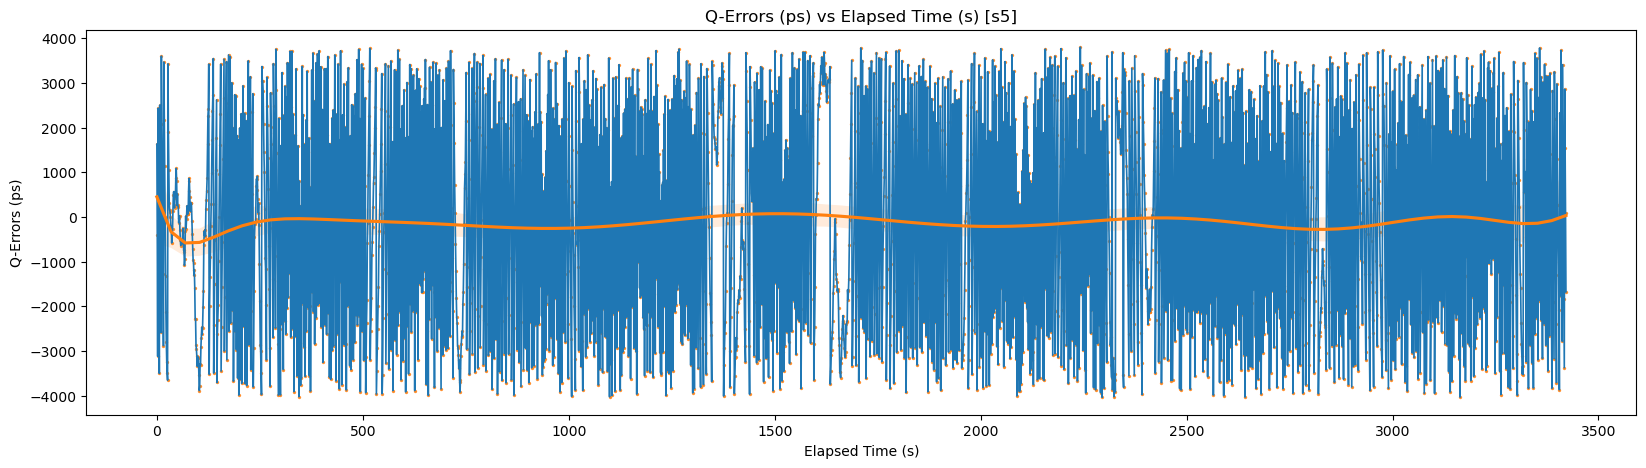

In [5]:
qerr_vs_time(s3, 's3'),qerr_vs_time(s5, 's5');

In [45]:
s3_tst = s3['unix_timestamp']
s5_tst = s5['unix_timestamp']
d_tst = d['unix_timestamp']

In [52]:
# Find latest start time among d, s3, and s5 dataframes.
d_aligned_idx = np.searchsorted(d_tst, min(s3_tst))
d_aligned_idx = max(d_aligned_idx, np.searchsorted(d_tst, min(s5_tst)))
latest_start_time = d_tst[d_aligned_idx]

# Find indices in s3 and s5 closest to latest start time.
s3_start_idx = np.searchsorted(s3_tst, latest_start_time)
s5_start_idx = np.searchsorted(s5_tst, latest_start_time)

print(s3['unix_timestamp'].iloc[s3_start_idx])
print(s5['unix_timestamp'].iloc[s5_start_idx])
print(d['unix_timestamp'].iloc[d_aligned_idx + 1])

# Trim data frames so that the earliest record is the latest starting time.
s3_aligned = s3[s3_start_idx:]
s5_aligned = s5[s5_start_idx:]
d_aligned = d[d_aligned_idx + 1:]

# Trim data frames to same length.
len_limit = min(len(d_aligned), len(s3_aligned), len(s5_aligned))
s3_aligned = s3_aligned[:len_limit]
s5_aligned = s5_aligned[:len_limit]
d_aligned = d_aligned[:len_limit]

2024-06-28 13:32:34.359186
2024-06-28 13:32:34.361470
2024-06-28 13:32:34.514167


In [11]:
print(s3_aligned.iloc[0, 0])
print(s5_aligned.iloc[0, 0])
print(d_aligned.iloc[0, 0])

2024-06-28 13:32:34.359186
2024-06-28 13:32:34.361470
2024-06-28 13:32:34.514167


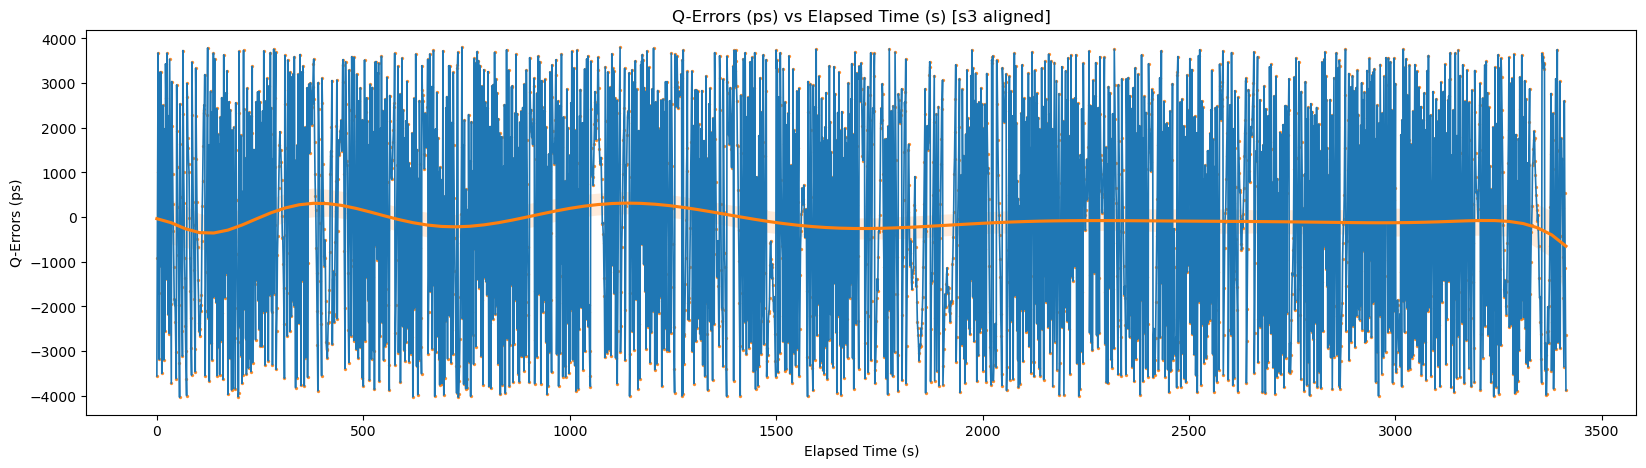

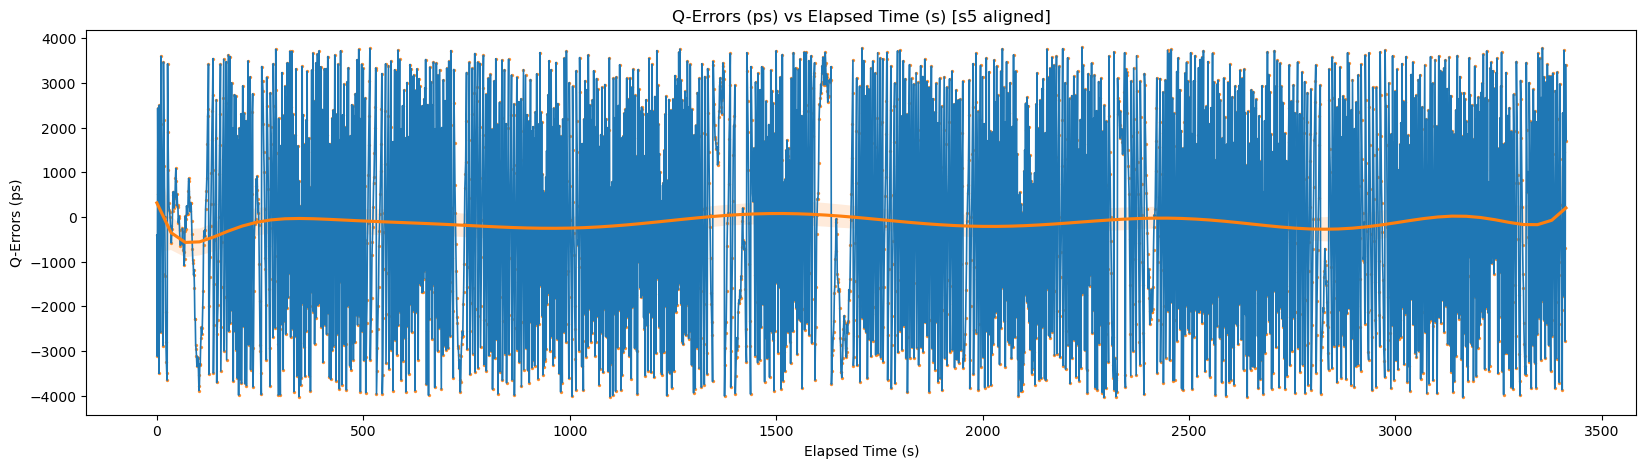

In [48]:
qerr_vs_time(s3_aligned, 's3 aligned'), qerr_vs_time(s5_aligned, 's5 aligned')

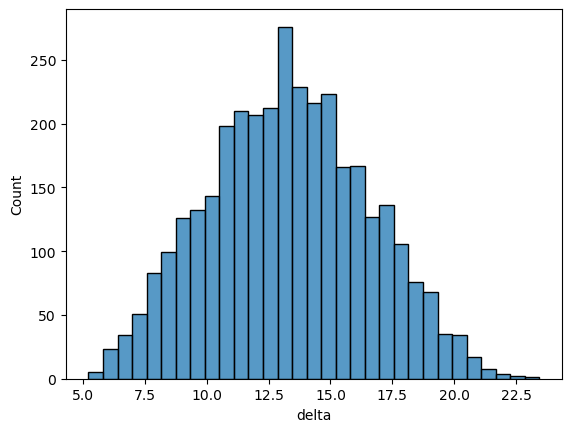

In [49]:
sns.histplot(d_aligned, x='delta');

In [50]:
# Original deltas
f, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(d_aligned, x='', y='qErr (ps)', linewidth=1.2, ax=ax)
sns.regplot(df, x='seconds elapsed', y='qErr (ps)', scatter=True, ax=ax, order=15, scatter_kws={'s':2})

ax.set_title(f'Q-Errors (ps) vs Elapsed Time (s) [{scope_name}]');
ax.set_xlabel('Elapsed Time (s)')
ax.set_ylabel('Q-Errors (ps)')

26     -3.555
27     -0.921
28      1.012
29      3.675
30     -1.709
        ...  
3435    2.603
3436    0.538
3437   -1.150
3438   -2.631
3439   -3.879
Name: qErr (ns), Length: 3414, dtype: float64